# 04 PyTorch Custom Datasets

How do we create our own custom datasets and get them into PyTorch?

Custom Datasets!

Depending on what you're working on, vision, text, audio, recommendation, etc. You'll want to look into each of the PyTorch domain libraries for existing data loading function and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/


## Importing PyTorch and setting up device agnostic code.

In [5]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device, torch.__version__

('cpu', '2.8.0+cu126')

## Get some data

Our dataset is a subset of the Food101 dataset.

Food101 starts with 101 different classes of food and 1000 images per class which is 750 training and 250 testing.

Our dataset starts with 3 classes of food and only 10% of the images. (75~ training, 25~ testing)

This helps us speed up the rate at which we can develop our test models and expiriments.

In [6]:
import requests
import zipfile
from pathlib import Path

# Set up a path to a data folder.
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it.
if image_path.is_dir():
  print(f"{image_path} - directory already exists, skipping download.")
else:
  print(f"{image_path} - directory doesn't exist, creating it.")
  image_path.mkdir(parents=True, exist_ok=True) # create parent dirs if necessary

# Download pizza, steak and sushi data
# create file ref for writing, will write the file after we download it.
# request.content will be the file content to be written.
with open(data_path / "pizza_steak_sushi.zip", "wb") as file:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi data...")
  file.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi - directory doesn't exist, creating it.
Unzipping pizza, steak and sushi data...


## Becoming one with the data (data preparation and data exploration)

In [7]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  # os.walk() goes thorugh the target dir and walks through each of the sub dirs, printing out a bit of info for each one.
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak


In [9]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's image library.
5. We'll then show the image and print metadata

Matplotlib reference: https://matplotlib.org/stable/tutorials/images.html

Random image path: data/pizza_steak_sushi/train/pizza/1524655.jpg
Image class: pizza
Image height: 512
Image width: 512


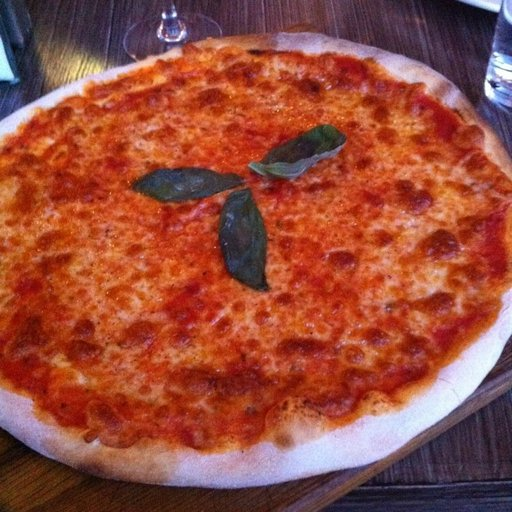

In [10]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all the image paths
# * first dir, * what's in the first dir, * any file that ends with jpg
image_path_list = list(image_path.glob("*/*/*.jpg")) # glob together all the images that belong to the path

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
random_image_path

# 3. Get image class from the path name (the directory)
image_class = random_image_path.parent.stem
image_class

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

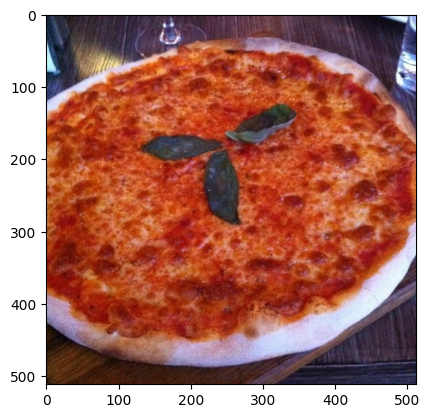

In [11]:
%matplotlib inline
# Visualize an image with Matplotlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

imgplot = plt.imshow(img)


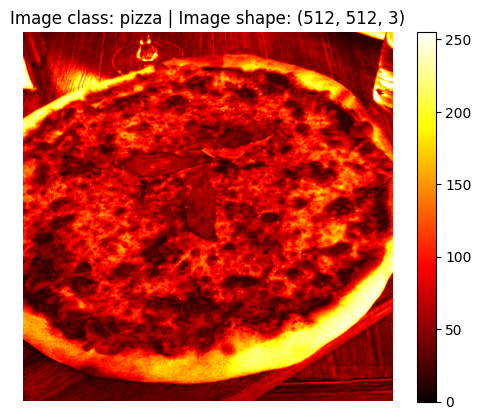

In [12]:
np_image_array = np.asarray(img)
lum_img = np_image_array[:, :, 1]

#plt.figure(figsize=(7, 5))
plt.imshow(lum_img, cmap="hot")
plt.title(f"Image class: {image_class} | Image shape: {np_image_array.shape}")
plt.axis(False)
plt.colorbar()

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader.


In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model and perform data augmentation.

In [14]:
# Write a transform for image
data_transform = transforms.Compose([
    # resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [15]:
# data_transform(img)

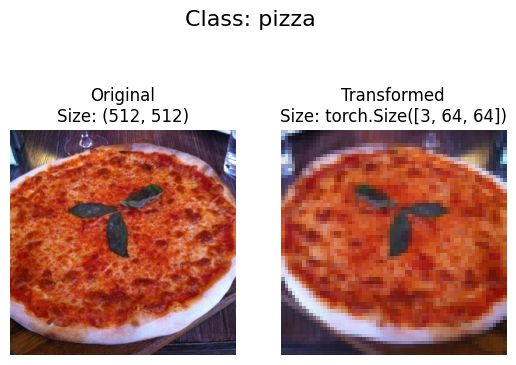

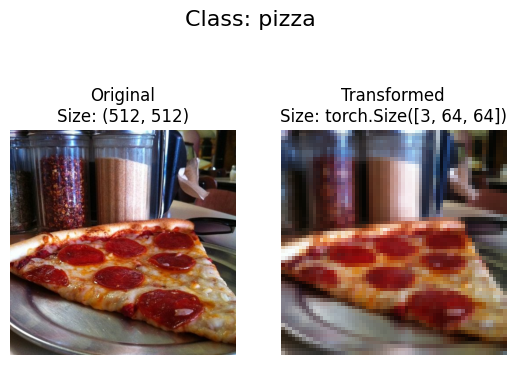

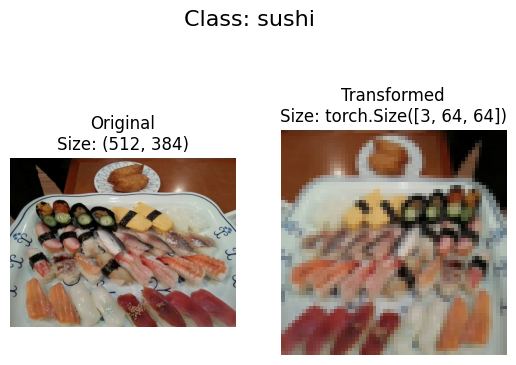

In [16]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads / transforms them, then plots the original compared to the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f)
      ax[1].imshow(transformed_image.permute(1, 2, 0))
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [17]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [18]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [19]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [20]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [21]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [22]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [23]:
# Index on the train_data Dataset to get a single image and label.
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [24]:
class_names[train_data[0][1]]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

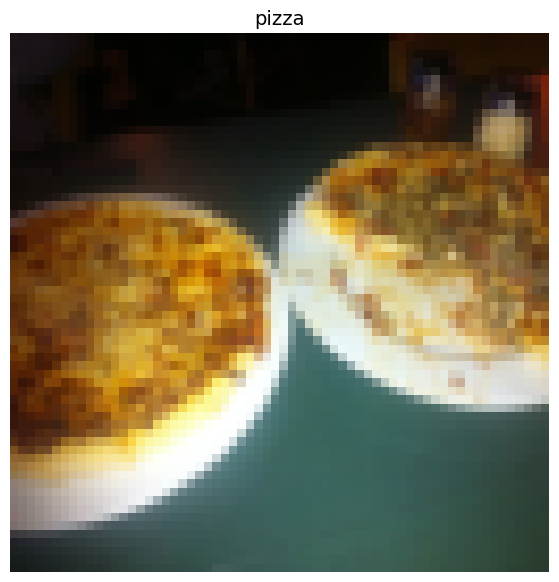

In [25]:
# Rearrange the order of the dimensions for matplotlib
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded images into `DataLoader`s

A `DataLoader` is going to help us turn our `Datasets` into interables.

In [26]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=1, shuffle=False)
train_data, test_dataloader

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 <torch.utils.data.dataloader.DataLoader at 0x7f2d5cb5c4a0>)

In [27]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## Option 2: Loading image data with a custom `Dataset`

In [28]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names

In [29]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")


Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [30]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [31]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [32]:
# Custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  def __init__(self, target_directory: str, transform=None) -> None:
    self.paths = list(pathlib.Path(target_directory).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(target_directory)

  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [33]:
from torchvision import transforms

# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


In [34]:
# Test our our custom Dataset class ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_directory=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom


(<__main__.ImageFolderCustom at 0x7f2d5c939c10>,
 <__main__.ImageFolderCustom at 0x7f2d60440c20>)

In [35]:
len(train_data), len(train_data_custom)

(225, 225)

In [36]:
len(test_data), len(test_data_custom)

(75, 75)

In [37]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [38]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [39]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)


True
True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameteters such as class names and how many images to visualize.
2. To prevent the display gettting out of hand, let's cap the number of images to display at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Set up a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [40]:
# 1. Create a function to take in a dataset.
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10. Setting n to 10.")

  # 3. Set the random seed for reproducibility.
  if seed:
    random.seed(seed)

  # 4. Get random sample index numbers.
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Set up the matplotlib plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, target_sample in enumerate(random_samples_idx):
    # get the random image and its class label.
    target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]

    # 7. Adjust tensor dimensions for plotting
    adjusted_target_image = target_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(adjusted_target_image)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[target_label]}"
      if display_shape:
        title = title + f"\nshape: {adjusted_target_image.shape}"
      plt.title(title)


In [71]:
class_names

['pizza', 'steak', 'sushi']

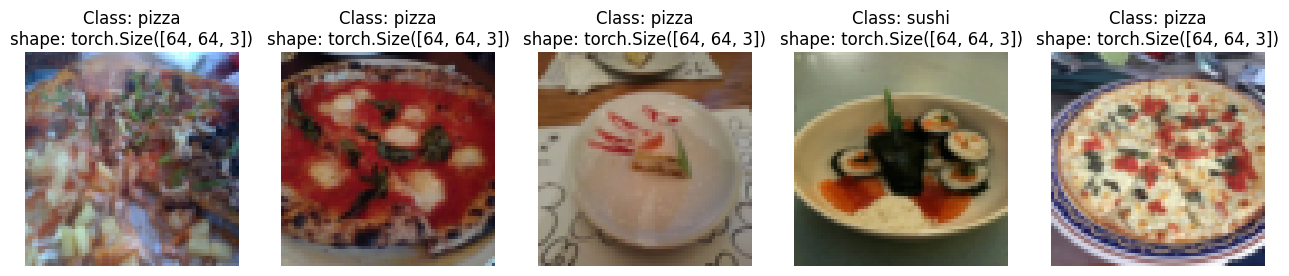

In [41]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10. Setting n to 10.


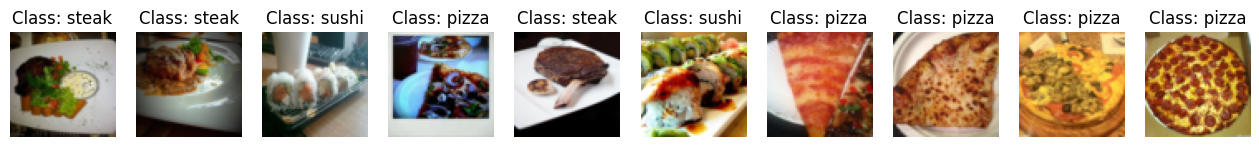

In [42]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

In [43]:
train_data_custom

### 5.4 Turn custom loaded images into `DataLoader`s

In [44]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_data_custom, test_dataloader_custom

(<__main__.ImageFolderCustom at 0x7f2d5c939c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2d5cab2db0>)

In [45]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of data augmentation (transforms)
https://en.wikipedia.org/wiki/Data_augmentation

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels.

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [46]:
# Let's look at TrivalAugment
from torchvision import transforms

train_trainsform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])


In [47]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/2924941.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2493954.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/320570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/853441.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2702825.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/618348.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3699992.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2885796.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/928670.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1033251.jpg')]

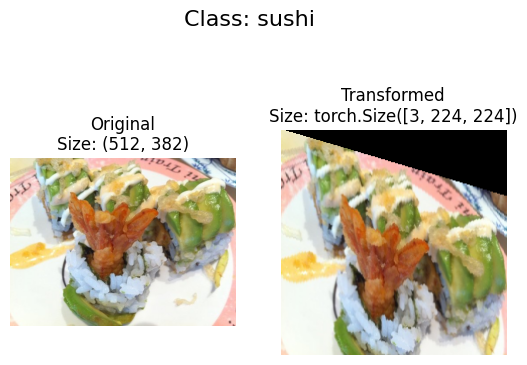

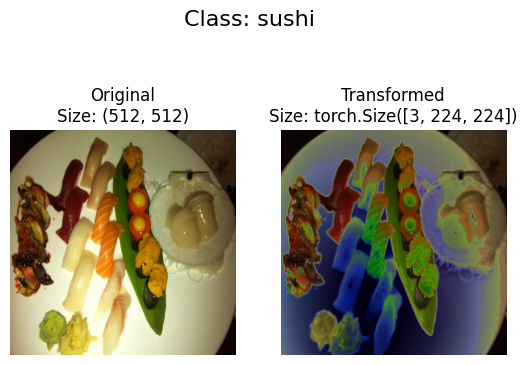

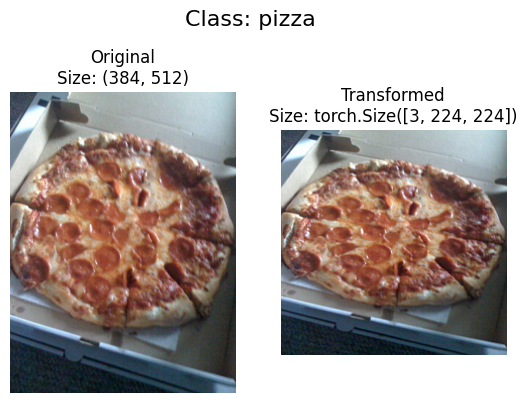

In [48]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_trainsform,
    n=3,
    seed=None
)

# 7. Model 0: TinyVGG without data augmentation

Check the CNN explainer site.

### 7.1 Creating transforms and loading data for Model 0

In [49]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [50]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform
)
test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

# 2. Turn the datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=train_data_simple,
    num_workers=NUM_WORKERS,
    shuffle=True
)
test_dataloader_simple = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=test_data_simple,
    num_workers=NUM_WORKERS,
    shuffle=False
)

### 7.2 Create TinyVGG Model Class

In [51]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from the CNN Explainer website.
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [52]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image to test the model

In [53]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [54]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [55]:
# Torchinfo - Print out a summary of our model.
# install it in Google Colab.
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [56]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loop functions

`train_step()`

`test_step()`

In [57]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate the accuracy. Get the total number of correct predictions
    # and divide it by the total number of samples.
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [58]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put the model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      # Get a single integer from loss.
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      #print(f"Test pred labels after argmax: {test_pred_labels}")
      #print(f"Sum of test_pred_labels: {(test_pred_labels == y).sum().item()}")
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


### 7.6 Creating a `train()` function

In [59]:
# Combine the train and test steps from above into a total train function
# allow for a configurable number of epoch runs.
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Run through some epochs. Let's go!
  for epoch in tqdm(range(epochs)):
    print(f"Epoch #: epoch")
    train_loss, train_acc = train_step(model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device)

    test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

    # Print out some stats
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results after all the epochs are complete
  return results



### 7.7 Train and evaluate model_0

In [60]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreated an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
total_train_time = end_time - start_time
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #: epoch
Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch #: epoch
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch #: epoch
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch #: epoch
Epoch: 3 | Train loss: 1.0842 | Train acc: 0.3984 | Test loss: 1.0608 | Test acc: 0.5833
Epoch #: epoch
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0654 | Test acc: 0.5644
Epoch #: epoch
Epoch: 5 | Train loss: 1.0305 | Train acc: 0.4336 | Test loss: 1.0139 | Test acc: 0.5426
Epoch #: epoch
Epoch: 6 | Train loss: 0.9854 | Train acc: 0.4219 | Test loss: 0.9323 | Test acc: 0.5938
Epoch #: epoch
Epoch: 7 | Train loss: 0.9663 | Train acc: 0.5781 | Test loss: 0.9986 | Test acc: 0.4432
Epoch #: epoch
Epoch: 8 | Train loss: 0.9238 | Train acc: 0.5977 | Test loss: 1.0669 | Test acc: 0.3324
Epoch #: epoch
Epoch: 9 | Train loss: 0.9969 | Train acc: 0.4648

### 7.8 Plot the loss curves of Model 0

https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

In [61]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of a results dictionary containing a list of
     loss and accuracy values.
  Example: {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  """
  # Get the loss values of the results dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary
  accuracy = results["train_acc"]
  test_acc = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Set up a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_acc, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



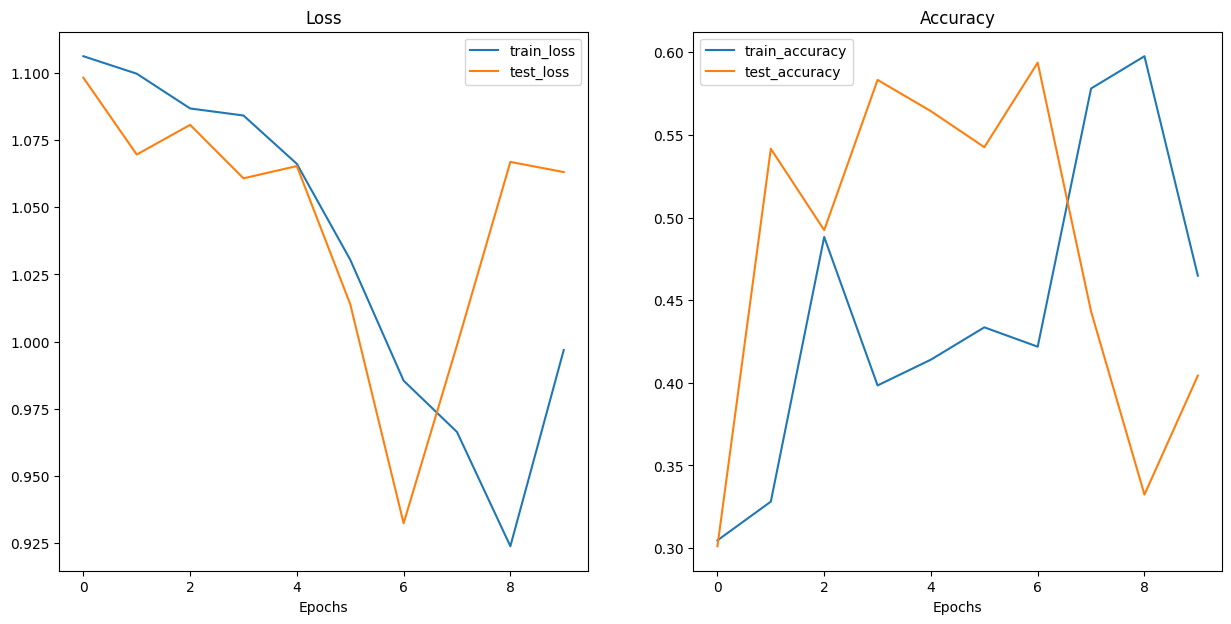

In [62]:
plot_loss_curves(model_0_results)

The result of the above expiriment shows that the ideal epochs at the current data set was around 8 epochs. Training beyond 8 overfits the model to the training data.

## 9. Model 1: TinyVGG with Data Augmentation



### 9.1 Create transform with data augmentation

In [63]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()

])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`s and `DataLoader`s with data augmentation

In [64]:
# Use ImageFolderCustom to create Datasets
train_data_custom_01 = ImageFolderCustom(target_directory=train_dir,
                                      transform=train_transform_trivial)
test_data_custom_01 = ImageFolderCustom(target_directory=test_dir,
                                     transform=test_transform_simple)
train_data_custom_01, test_data_custom_01

(<__main__.ImageFolderCustom at 0x7f2d5ca57620>,
 <__main__.ImageFolderCustom at 0x7f2d5c466ff0>)

In [66]:
# Create DataLoaders from train_data_custom_01 and test_data_custom_01
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom_01 = DataLoader(dataset=train_data_custom_01,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom_01 = DataLoader(dataset=test_data_custom_01,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_dataloader_custom_01, test_dataloader_custom_01

(<torch.utils.data.dataloader.DataLoader at 0x7f2d5cab1c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2d603e6f60>)

In [73]:
class_names_01, class_to_idx_01 = find_classes(test_dir)
class_names_01
#len(class_names_01)

['pizza', 'steak', 'sushi']

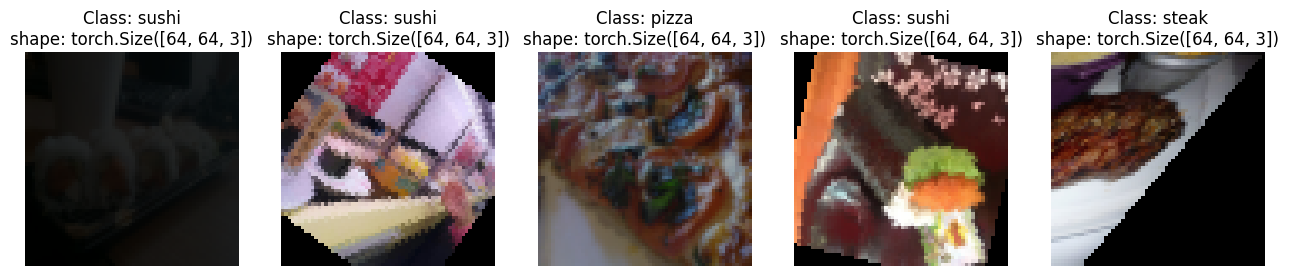

In [74]:
display_random_images(train_data_custom_01,
                      n=5,
                      classes=class_names_01,
                      seed=None)

### 9.3 Construct and train model_1 (TinyVGG) with dataset augmentation.

In [75]:
# Construct model_1
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names_01)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [76]:
# Train model_1
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_custom_01,
                        test_dataloader=test_dataloader_custom_01,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
total_train_time = end_time - start_time
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #: epoch
Epoch: 0 | Train loss: 1.1036 | Train acc: 0.2617 | Test loss: 1.0993 | Test acc: 0.2604
Epoch #: epoch
Epoch: 1 | Train loss: 1.0793 | Train acc: 0.4258 | Test loss: 1.1270 | Test acc: 0.2604
Epoch #: epoch
Epoch: 2 | Train loss: 1.0713 | Train acc: 0.4258 | Test loss: 1.1518 | Test acc: 0.2604
Epoch #: epoch
Epoch: 3 | Train loss: 1.1209 | Train acc: 0.3047 | Test loss: 1.1279 | Test acc: 0.2604
Epoch #: epoch
Epoch: 4 | Train loss: 1.0896 | Train acc: 0.3008 | Test loss: 1.1081 | Test acc: 0.2907
Epoch #: epoch
Epoch: 5 | Train loss: 1.0857 | Train acc: 0.3164 | Test loss: 1.1163 | Test acc: 0.2907
Epoch #: epoch
Epoch: 6 | Train loss: 1.0622 | Train acc: 0.3555 | Test loss: 1.0879 | Test acc: 0.3835
Epoch #: epoch
Epoch: 7 | Train loss: 1.0755 | Train acc: 0.3633 | Test loss: 1.0883 | Test acc: 0.3939
Epoch #: epoch
Epoch: 8 | Train loss: 1.0601 | Train acc: 0.4688 | Test loss: 1.1023 | Test acc: 0.3930
Epoch #: epoch
Epoch: 9 | Train loss: 1.0660 | Train acc: 0.3555

### Plot the loss curves

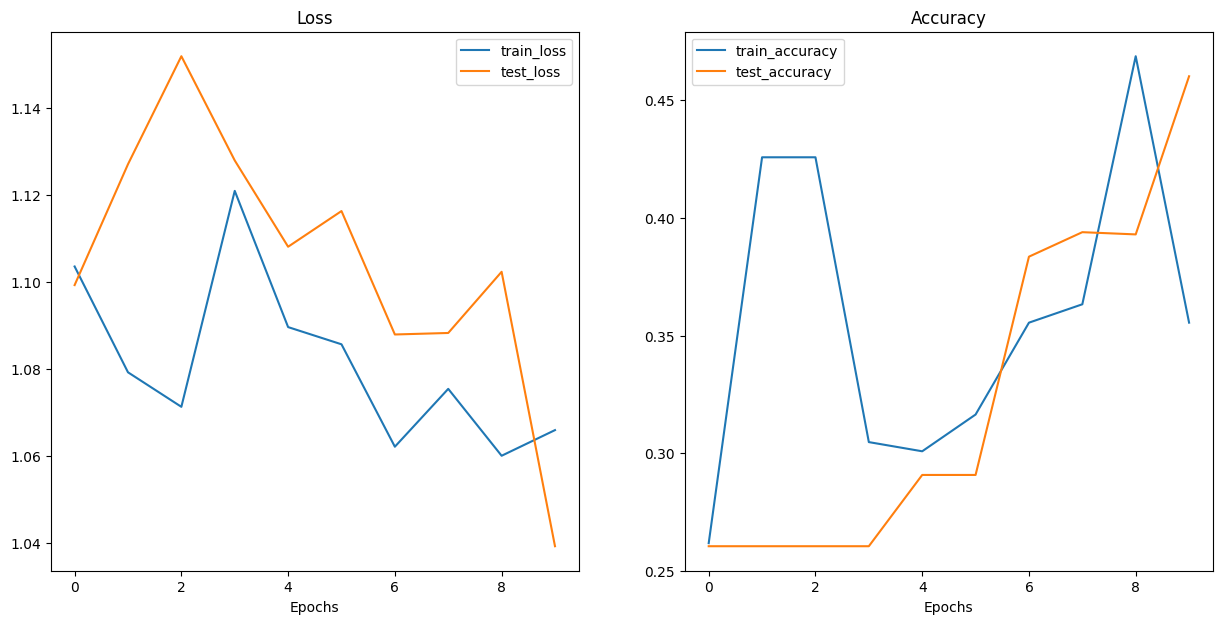

In [77]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modeling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we have done so far)
2. PyTorch + Tensorboard
3. Weights & Biases - https://wandb.ai
4. mlflow - https://mlflow.org

In [80]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394
5,1.030505,0.433594,1.013929,0.542614
6,0.985439,0.421875,0.932304,0.593750
7,0.966324,0.578125,0.998642,0.443182
8,0.923759,0.597656,1.066946,0.332386
9,0.996855,0.464844,1.063165,0.404356


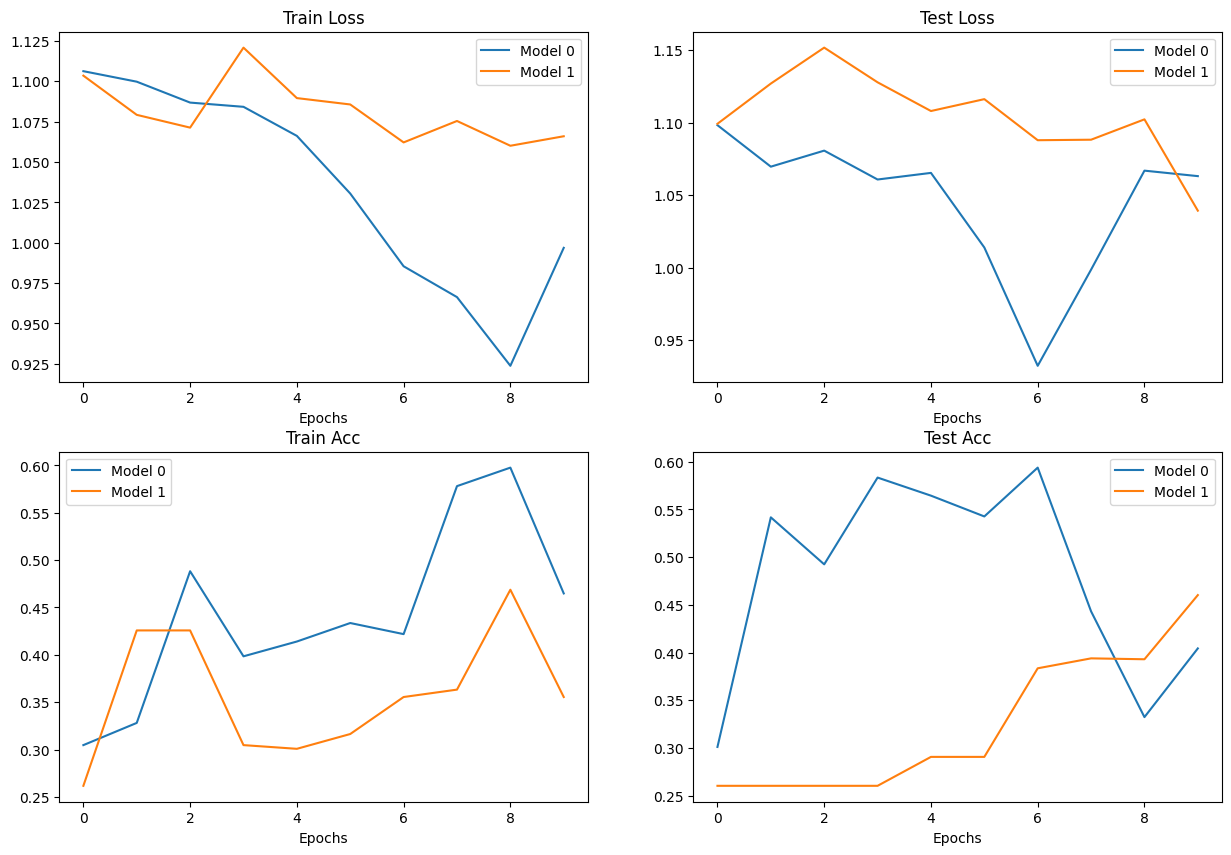

In [83]:
# Set up a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test acc
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

In [84]:
# Download a custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from Github, use the raw file link.
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with data type `torch.float32`
* Of shape 64x64x3
* Make sure it's on the right device

For more information, see: https://docs.pytorch.org/vision/0.19/auto_examples/others/plot_repurposing_annotations.html#sphx-glr-auto-examples-others-plot-repurposing-annotations-py

In [89]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")


Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

In [88]:
#plt.imshow(custom_image_uint8.permute(1, 2, 0))